In [8]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class MaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory containing 'Mask' and 'No Mask' folders.
            transform (callable, optional): Transformations to be applied to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["Mask", "No Mask"]  # Label directories
        self.image_paths = []  # Store all image paths
        self.labels = []       # Store corresponding labels

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(label)  # 0 for Mask, 1 for No Mask

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and its label


In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1]
])


In [9]:
from torch.utils.data import DataLoader, random_split

# Initialize the dataset
dataset = MaskDataset(root_dir="dataset", transform=transform)

# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Print dataset info
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Training samples: 271
Validation samples: 68


Images shape: torch.Size([8, 3, 256, 256])
Labels shape: torch.Size([8])


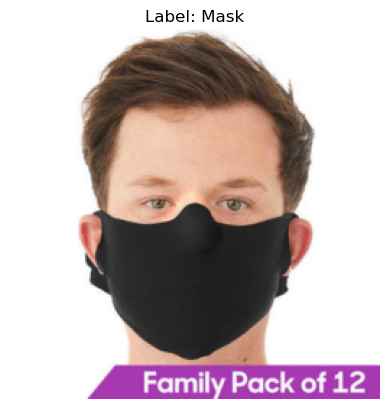

In [21]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import matplotlib.pyplot as plt

# Get a batch of images
try:
    images, labels = next(iter(train_loader))
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
except Exception as e:
    print(f"Error fetching data from train_loader: {e}")

# Visualize the first image and its label
try:
    plt.imshow(images[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Undo normalization for display
    plt.title("Label: Mask" if labels[0] == 0 else "Label: No Mask")
    plt.axis("off")
    plt.show()
except Exception as e:
    print(f"Error displaying image: {e}")

In [22]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class MaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["Mask", "No Mask"]
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):  # Check if the file exists
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [23]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def double_conv(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.down1 = double_conv(in_channels, 64)
        self.down2 = double_conv(64, 128)
        self.down3 = double_conv(128, 256)
        self.down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.conv_up3 = double_conv(512, 256)
        self.conv_up2 = double_conv(256, 128)
        self.conv_up1 = double_conv(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Downsampling path
        x1 = self.down1(x)
        x2 = self.down2(self.maxpool(x1))
        x3 = self.down3(self.maxpool(x2))
        x4 = self.down4(self.maxpool(x3))

        # Upsampling path
        x = self.up3(x4)
        x = self.conv_up3(torch.cat([x3, x], dim=1))

        x = self.up2(x)
        x = self.conv_up2(torch.cat([x2, x], dim=1))

        x = self.up1(x)
        x = self.conv_up1(torch.cat([x1, x], dim=1))

        return self.final(x)


In [ ]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

# Define model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1).to(device)

criterion = nn.BCEWithLogitsLoss()  # Use Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, leave=False)
    epoch_loss = 0

    for images, masks in loop:
        try:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())
        except Exception as e:
            print(f"Error: {e}")
            continue

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")


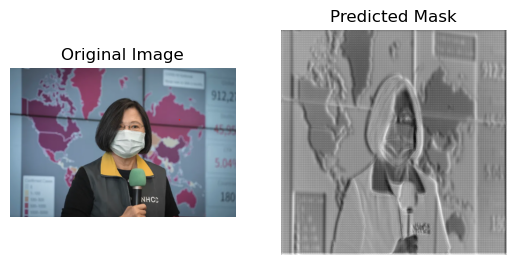

In [24]:
import matplotlib.pyplot as plt

# Model inference
def visualize_prediction(image_path, model):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = torch.sigmoid(model(image_tensor))
        prediction = prediction.squeeze().cpu().numpy()

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap="gray")
    plt.axis("off")

    plt.show()

# Example usage
visualize_prediction("sample2.png", model)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, dataloader, device, is_segmentation=False):
    """
    Evaluate a PyTorch model on classification or segmentation tasks.
    
    Args:
        model: PyTorch model
        dataloader: PyTorch dataloader
        device: torch device
        is_segmentation: bool, whether this is a segmentation task
    """
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            if is_segmentation:
                # For segmentation, average predictions across spatial dimensions
                predictions = torch.argmax(outputs, dim=1)  # [B, H, W]
                predictions = predictions.view(predictions.size(0), -1).float()  # [B, H*W]
                predictions = predictions.mean(dim=1).round().long()  # [B]
                labels = labels.view(labels.size(0), -1).float().mean(dim=1).round().long()  # [B]
            else:
                # For classification, just get the predicted class
                predictions = torch.argmax(outputs, dim=1)  # [B]
            
            # Collect predictions and labels
            all_preds.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    
    # Debug information
    print(f"Label count: {len(all_labels)}, Prediction count: {len(all_preds)}")
    print("Unique labels in dataset:", set(all_labels))
    print("Unique predictions in dataset:", set(all_preds))
    
    # Ensure labels and predictions match
    if len(all_labels) != len(all_preds):
        raise ValueError(f"Mismatch: {len(all_labels)} labels vs {len(all_preds)} predictions")
    
    # Compute metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='macro', zero_division=1),
        'recall': recall_score(all_labels, all_preds, average='macro', zero_division=1),
        'f1': f1_score(all_labels, all_preds, average='macro', zero_division=1),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }
    
    # Print metrics
    print("\nModel Evaluation Metrics:")
    print("-" * 25)
    for metric, value in metrics.items():
        if metric != 'confusion_matrix':
            print(f"{metric.capitalize()}: {value:.4f}")
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    
    return metrics

# Example usage:
# For classification:
# evaluate_model(model, val_loader, device, is_segmentation=False)

# For segmentation:
evaluate_model(model, val_loader, device, is_segmentation=True)

Label count: 68, Prediction count: 68
Unique labels in dataset: {0, 1}
Unique predictions in dataset: {0, 1}

Model Evaluation Metrics:
-------------------------
IoU: 0.8416859
Accuracy: 0.90428192
Precision: 0.9806
Recall: 0.8632
F1: 0.9182
Dice Score: 0.89354841
Confusion Matrix:
[[-1  1]
 [10 58]]
